In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/NESTQUANT/data

[Errno 2] No such file or directory: 'gdrive/MyDrive/NESTQUANT/data'
/content/gdrive/MyDrive/NESTQUANT/data/predicted_data


In [ ]:
import os
import gc
import math
import sklearn
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime

In [1]:
path = '/content/gdrive/MyDrive/NESTQUANT/data/'
path_ETHUSDT = path+ 'coin/ETHUSDT'
path_LTCUSDT = path+ 'coin/LTCUSDT'
path_CPILFESL = path + 'FRED/CPILFESL.parquet'
path_EURUSD = path + 'fx/C_EURUSD'
path_SPY = path+'stock/SPY'


In [2]:
def get_return(df, time, name):
    dff = df.copy()
    dff[f'RETURN_{name}_{time}'] = np.log(dff[f'CLOSE_{name}'] / dff[f'CLOSE_{name}'].shift(time))
    return dff

def get_vola(df, time, isReturn, name):
    dff = df.copy()
    if isReturn == False:
        dff = get_return(dff, 1)
    dff[f"std_{time}"] = dff[f'RETURN_{name}_1'].rolling(window=time).std()
    dff["std_long"] = dff[f'RETURN_{name}_1'].rolling(window=336).std()
    dff[f"VOLABILITY_{name}_{time}"]  = dff[f"std_{time}"]/ dff["std_long"]

    dff = dff.drop(f"std_{time}", axis = 1)
    dff = dff.drop("std_long", axis = 1)

    return dff


def preprocess_df(df, name, start, end):
    for col in df.columns:
        if (col == 'YEAR_AND_MONTH') | (col =="SYMBOL"):
            df = df.drop(col, axis = 1)
        else:
            df[f'{col}_{name}'] = df[col]
            df = df.drop(col, axis = 1)

    for i in range(start, end):
        df = get_return(df, i, name)
        if i == 1:
            continue
        else:
            df = get_vola(df, i, True, name)

    return df

In [ ]:
df_Label = pd.read_csv(path + 'BTC/BTCUSDT_label.csv')
df_BTC = pd.read_csv(path + 'BTC/BTCUSDT_obeserved.csv')

In [ ]:
df_Label = df_Label.set_index("OPEN_TIME")
df_BTC = df_BTC.set_index("OPEN_TIME")

In [ ]:
df_BTCLabel = df_BTC.join(df_Label, how='inner')
df_BTCLabel = df_BTCLabel.drop(columns=["YEAR_AND_MONTH","SYMBOL"])
df_BTCLabel = preprocess_df(df_BTCLabel, "BTC",1, 24)
df_ETHUSDT = preprocess_df(pd.read_parquet(path_ETHUSDT),"ETHUSDT", 1, 24)
df_LTCUSDT = preprocess_df(pd.read_parquet(path_LTCUSDT),"LTCUSDT",1, 24)
#df_CPILFESL = preprocess_df(pd.read_parquet(path_CPILFESL))
df_EURUSD = preprocess_df(pd.read_parquet(path_EURUSD),"EURUSD", 1, 24)
df_SPY = preprocess_df(pd.read_parquet(path_SPY),"SPY", 1, 24)



KeyboardInterrupt: ignored

In [ ]:
df_BTCLabel = df_BTCLabel.dropna()
df_ETHUSDT = df_ETHUSDT.dropna()
df_LTCUSDT = df_LTCUSDT.dropna()
df_EURUSD = df_EURUSD.dropna()
df_SPY = df_SPY.dropna()

In [ ]:
import pandas as pd

# Original dataframe
def get_dupp(dff):
# Convert the 'date' column to datetime type
    dff['DATE'] = pd.to_datetime(dff['DATE'])

    # Create a new dataframe to store the expanded rows
    expanded_dff = pd.DataFrame()

    # Iterate over each row in the original dataframe
    for index, row in dff.iterrows():
        date = row['DATE']
        values = row[1:]  # Exclude the 'date' column

        # Create a datetime range for the 24 hours of the day
        hour_range = pd.date_range(date, periods=24, freq='H')

        # Create a temporary dataframe with the expanded rows
        temp_dff = pd.DataFrame(hour_range, columns=['DATE'])

        # Duplicate the values for each hour
        for column, value in zip(dff.columns[1:], values):
            temp_dff[column] = value

        # Append the temporary dataframe to the expanded dataframe
        expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
    return expanded_dff


In [ ]:
df_CPILFESL = pd.read_parquet(path_CPILFESL)
df_CPILFESL = get_dupp(df_CPILFESL)
df_CPILFESL["OPEN_TIME"] = df_CPILFESL["DATE"].apply(lambda x: int(datetime.timestamp(x)) *1000)
df_CPILFESL = df_CPILFESL.drop("DATE", axis= 1)
df_CPILFESL = df_CPILFESL.set_index("OPEN_TIME")

In [ ]:
df_BTCLabel1 = df_BTCLabel.join(df_ETHUSDT, how = 'inner')
df_BTCLabel2 = df_BTCLabel1.join(df_EURUSD, how="left").bfill().ffill()
df_BTCLabel3 = df_BTCLabel2.join(df_LTCUSDT, how="left").bfill().ffill()
df_BTCLabel4 = df_BTCLabel3.join(df_SPY, how="left").bfill().ffill()
df_BTCLabel5 = df_BTCLabel4.join(df_CPILFESL, how="left").bfill().ffill().reset_index()

In [ ]:
df_BTCLabel5

In [ ]:
x = df_BTCLabel5.drop(['LABEL_BTC'],axis=1)
y = df_BTCLabel5["LABEL_BTC"]

# train and test split
# x,_,y,_ = train_test_split(x,y,test_size=0.01, shuffle=False)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.1, shuffle=False)
# _,x_train,__,y_train = train_test_split(x_train,y_train,test_size=0.6, shuffle=False)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)

In [ ]:
train_data = lgb.Dataset(x_train, label=pd.DataFrame(y_train))
valid_data = lgb.Dataset(pd.DataFrame(x_valid), label=pd.DataFrame(y_valid), reference=train_data)

In [ ]:
x_test

In [ ]:
time = x_train.OPEN_TIME.tolist()

In [ ]:
len(time)

In [ ]:
delta = 24
start_training_OPEN_TIME = 1000
model_predicted_scores = []
current_predicted_scores = []
cur_score_predict_tops = []
pred_score_predict_tops = []

for i in range(start_training_OPEN_TIME, len(time), delta):
    tmp_train_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i-start_training_OPEN_TIME])&(df_BTCLabel5.OPEN_TIME < time[i-delta//2])]
    x_train = tmp_train_df.drop(['LABEL_BTC'],axis=1)
    y_train = tmp_train_df["LABEL_BTC"]

    tmp_valid_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i-delta//2])&(df_BTCLabel5.OPEN_TIME < time[i])]
    x_valid = tmp_valid_df.drop(['LABEL_BTC'],axis=1)
    y_valid = tmp_valid_df["LABEL_BTC"]

    tmp_test_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time[i])&(df_BTCLabel5.OPEN_TIME < time[i+delta])]
    x_test = tmp_test_df.drop(['LABEL_BTC'],axis=1)
    y_test = tmp_test_df["LABEL_BTC"]

    train_data = lgb.Dataset(x_train, label=pd.DataFrame(y_train), params={'verbose': -1})
    valid_data = lgb.Dataset(pd.DataFrame(x_valid), label=pd.DataFrame(y_valid), params={'verbose': -1}, reference=train_data)

    print("Train, Valid, Test size: ", x_train.shape[0], x_valid.shape[0], x_test.shape[0])

    param = {
        'boosting_type': 'goss',
        'max_depth': 4,
        'num_leaves': 15,
        'learning_rate': 0.08,
        'objective': "regression",
        'early_stopping_rounds': 64,
        'metric': 'mse',
        'num_boost_round': 100,
        'num_iterations': 512
    #     'bagging_fraction': 0.8
    }

    model = lgb.train(
        param,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        verbose_eval=False
    )
    model_predicted_scores.append([(model.predict(x_train)-y_train).abs().mean(), (model.predict(x_valid)-y_valid).abs().mean(), (model.predict(x_test)-y_test).abs().mean()])




In [ ]:
x_test

In [ ]:
y_test

In [ ]:
pred=model.predict(x_test)
submit=pd.DataFrame(columns=['OPEN_TIME','PREDICTION'])
submit['OPEN_TIME']=x_test["OPEN_TIME"]
submit['PREDICTION']=pred.flatten()

testt=pd.DataFrame(columns=['TEST','PREDICTION'])

testt['TEST']=y_test
testt['PREDICTION']=pred.flatten()


In [ ]:
testt.corr()

In [ ]:
submit

In [ ]:
cd predicted_data

In [ ]:
submit.to_csv("test2.csv")

In [ ]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(test)
plt.legend(['test','predict'])
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_squared_error(y_test,pred),2)
mae=np.round(mean_squared_error(y_test,pred),2)
plt.text(x=500, y=1.5,s='R2 Score : {}'.format(r2))
plt.text(x=500, y=1.35,s='Mean Squared error : {}'.format(mse))
plt.text(x=500, y=1.25,s='Mean Absolute error : {}'.format(mae))

In [ ]:
plt.figure(figsize=(16,9), dpi=90)
plt.title("MAE")
plt.plot(pd.DataFrame(model_predicted_scores)[2], label="LightGBM model")
plt.xlabel("Round")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,9), dpi=90)
plt.title("Test score histogram")
plt.hist(model.predict(x_test), bins=20)
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [ ]:
pred=model.predict(x_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
test

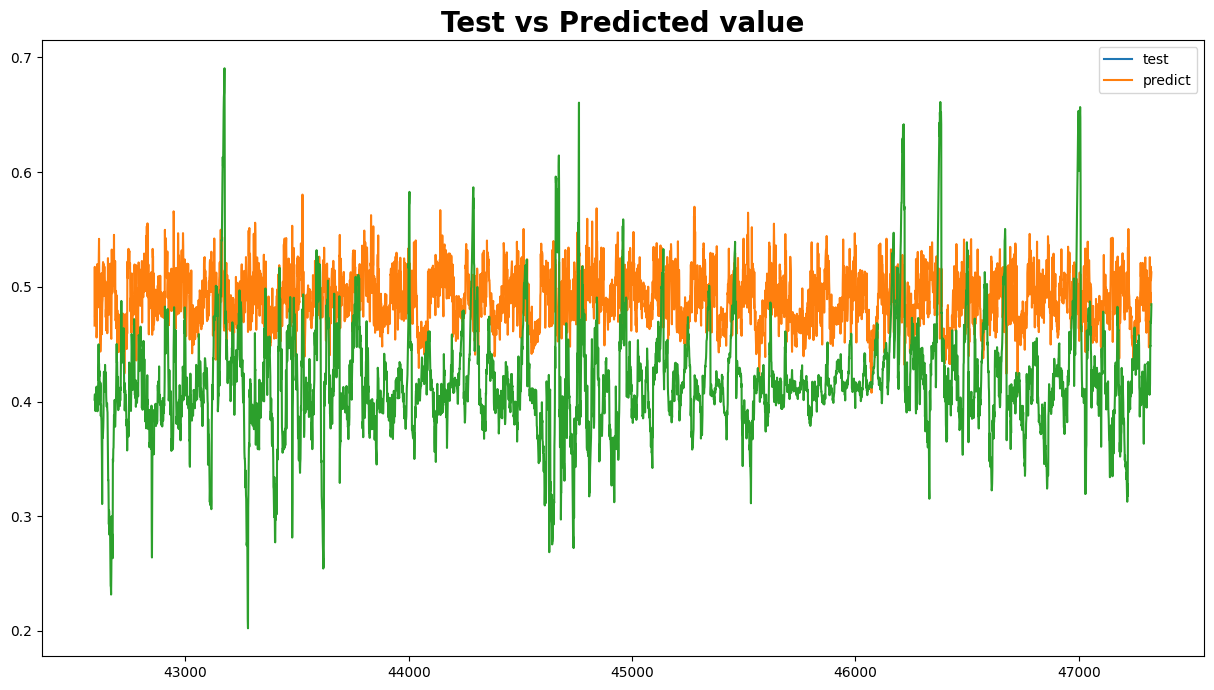

In [ ]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(testt)
plt.legend(['test','predict'])


In [ ]:
model

In [ ]:
pred=model.predict(x_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
test

,test,pred
37860,0.358646,0.422477
37861,0.379284,0.422477
37862,0.362157,0.422477
37863,0.385676,0.422477
37864,0.424506,0.422477
...,...,...
47321,0.448246,0.423477
47322,0.470401,0.422955
47323,0.468764,0.422955
47324,0.474988,0.422955


In [ ]:
feat_imp = pd.DataFrame([model.feature_name(), model.feature_importance('gain')]).T
feat_imp.columns=['Name', 'Feature Importance']
feat_imp

,Name,Feature Importance
0,OPEN_TIME,2.394933
1,OPEN_BTC,1.195493
2,HIGH_BTC,0.450788
3,LOW_BTC,0.326401
4,CLOSE_BTC,0.198712
...,...,...
261,RETURN_SPY_22,0.056475
262,VOLABILITY_SPY_22,0.052499
263,RETURN_SPY_23,0.039729
264,VOLABILITY_SPY_23,0.009956


In [ ]:
plot_feat_imp = feat_imp.sort_values("Feature Importance", ascending=False).iloc[:50,:]

In [ ]:
def cal_log(x):
    return np.log10(x)

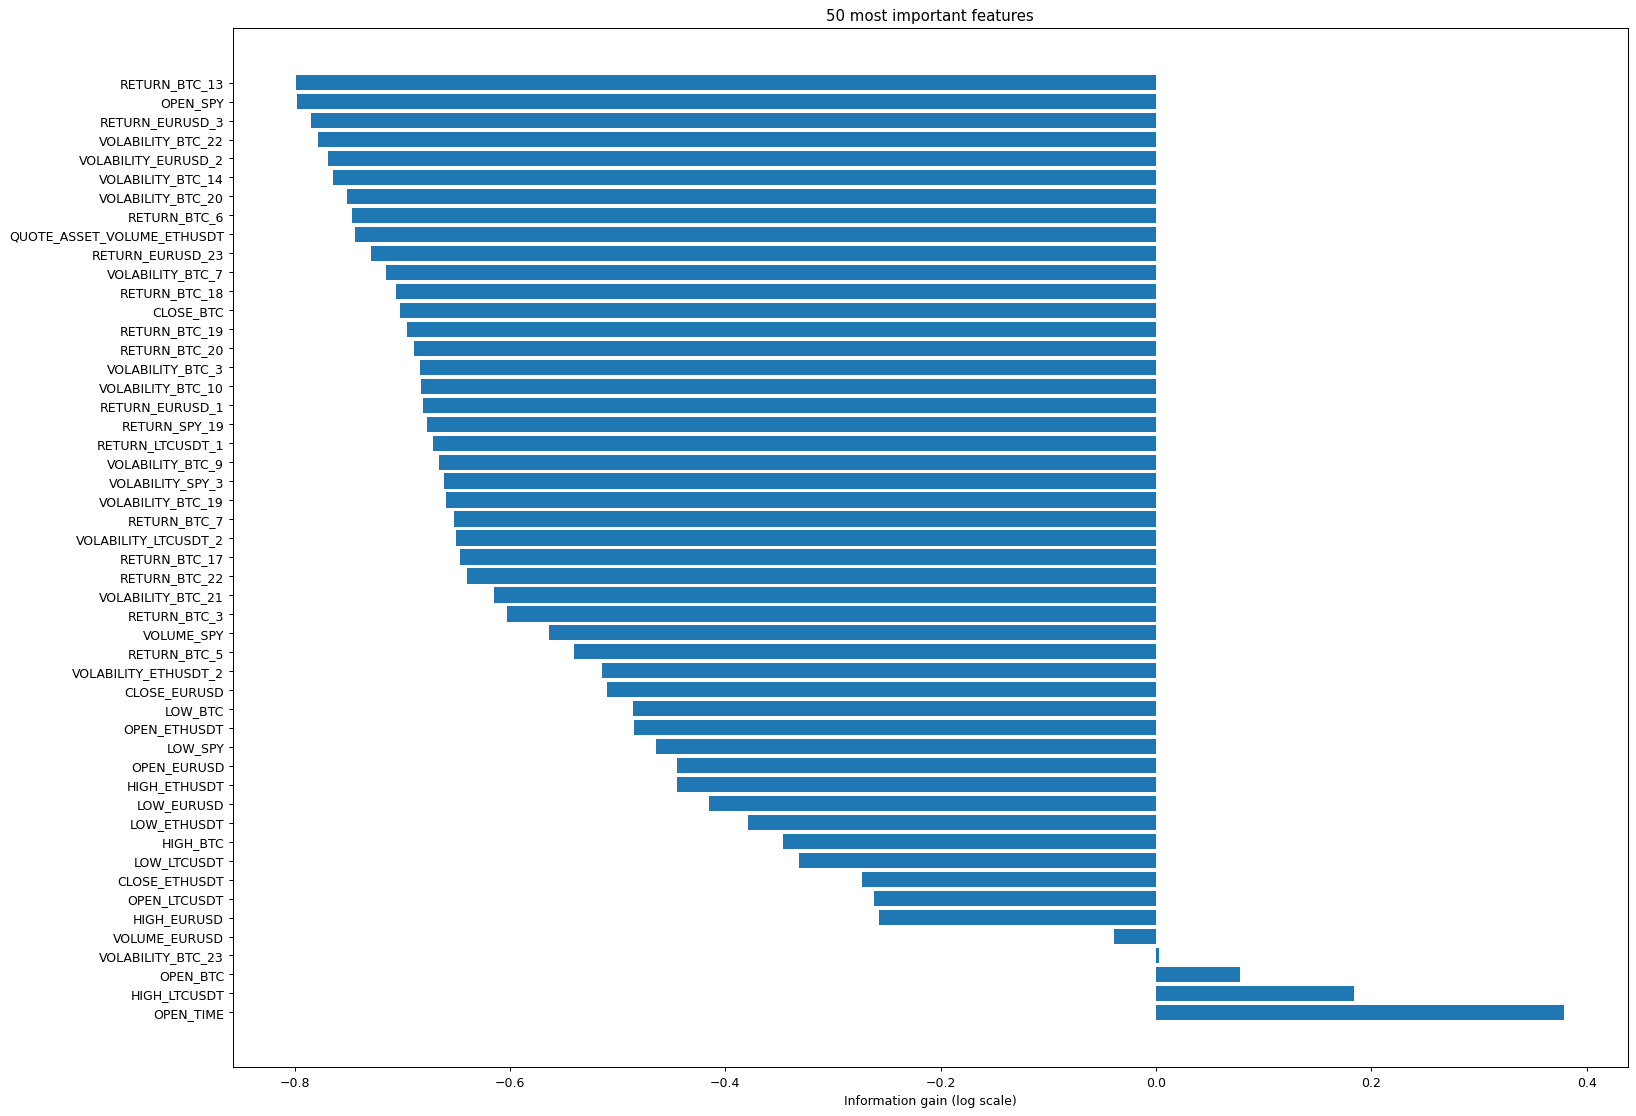

In [ ]:
plt.figure(figsize=(20,15), dpi=90)
plt.title("50 most important features")
plt.barh(plot_feat_imp["Name"],plot_feat_imp["Feature Importance"].apply(cal_log))
plt.xlabel("Information gain (log scale)")
plt.show()